In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from scipy.fftpack import dct
from sklearn.neighbors import KNeighborsClassifier

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.figure import Figure
import seaborn as sns



DIR = './ORL/renamed'
IMAGESCOUNT = 400
CLASSCOUNT = 40
LABELS = ['HIST', 'DFT', 'DCT', 'SCALE', 'GRAD', 'MAJOR']
W = 70
H = 80


### Определение типов классификаторов, параметров и эталонов лиц

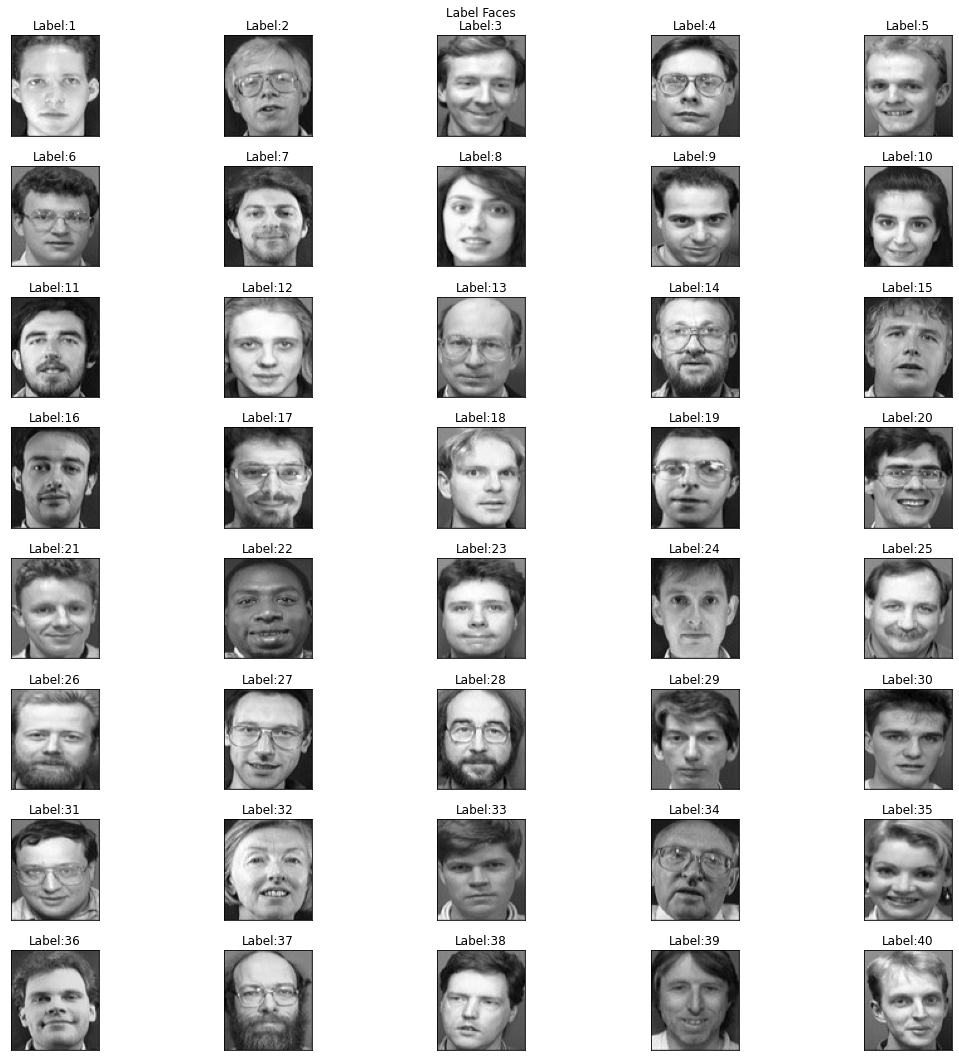

In [119]:
class TypeClassifier:
    HIST = 0
    DFT = 1
    DCT = 2
    SCALE = 3
    GRAD = 4

class TypeParams:
    HIST = [round(i) for i in np.linspace(1, 255, 12)] # количество бинов
    DFT = [i for i in range(1, min(H, W)+1, 3)] # взятая в рассмотрение длина 
    DCT = [i for i in range(1, min(H, W)+1, 3)] # взятая в рассмотрение длина
    SCALE = [round(i, 2) for i in np.linspace(0, 1, 25)[1:]] # взятая в рассмотрение часть от целого
    GRAD = [i for i in range(1, round(H/2)+1, 5)] # высота скользящего окна

# orl_imgs = [os.path.join(DIR, f'{i}_{j}.jpg') for i in range(1, IMAGESCOUNT + 1) for j in range (1, CLASSCOUNT + 1) if (i//10==j and i%10==0) or (i//10+1==j and i%10!=0)]
# all_files_names = [f'{i}_{j}.jpg' for i in range (1, CLASSCOUNT + 1) for j in range(1, IMAGESCOUNT//CLASSCOUNT + 1)]
all_files_names = []
all_labels = []
for i in range(1, CLASSCOUNT+1):
    for j in range(1, IMAGESCOUNT//CLASSCOUNT+1):
        all_files_names.append(f'{i}_{j}.jpg')
        all_labels.append(i)
all_images = np.array([cv2.imread(DIR+'/'+filename, 0) for filename in all_files_names])
all_labels = np.array(all_labels)

LabelFace = { 
    1: DIR+'/1_1.jpg',
    2: DIR+'/2_1.jpg',
    3: DIR+'/3_1.jpg',
    4: DIR+'/4_1.jpg',
    5: DIR+'/5_1.jpg',
    6: DIR+'/6_1.jpg',
    7: DIR+'/7_1.jpg',
    8: DIR+'/8_1.jpg',
    9: DIR+'/9_1.jpg',
    10: DIR+'/10_1.jpg',
    11: DIR+'/11_1.jpg',
    12: DIR+'/12_1.jpg',
    13: DIR+'/13_1.jpg',
    14: DIR+'/14_1.jpg',
    15: DIR+'/15_1.jpg',
    16: DIR+'/16_1.jpg',
    17: DIR+'/17_1.jpg',
    18: DIR+'/18_1.jpg',
    19: DIR+'/19_1.jpg',
    20: DIR+'/20_1.jpg',
    21: DIR+'/21_1.jpg',
    22: DIR+'/22_1.jpg',
    23: DIR+'/23_1.jpg',
    24: DIR+'/24_1.jpg',
    25: DIR+'/25_1.jpg',
    26: DIR+'/26_1.jpg',
    27: DIR+'/27_1.jpg',
    28: DIR+'/28_1.jpg',
    29: DIR+'/29_1.jpg',
    30: DIR+'/30_1.jpg',
    31: DIR+'/31_1.jpg',
    32: DIR+'/32_1.jpg',
    33: DIR+'/33_1.jpg',
    34: DIR+'/34_1.jpg',
    35: DIR+'/35_1.jpg',
    36: DIR+'/36_1.jpg',
    37: DIR+'/37_1.jpg',
    38: DIR+'/38_1.jpg',
    39: DIR+'/39_1.jpg',
    40: DIR+'/40_1.jpg',
    41: DIR+'/41_1.jpg'
}


fig = plt.figure(figsize=(16, 15)) 
plt.suptitle('Label Faces')

for i in range(1, CLASSCOUNT+1):
    plt.subplot(8, 5, i)
    image = cv2.imread(LabelFace[i], 0)
    plt.imshow(image, cmap='gray'), plt.title(f'Label:{i}')
    plt.xticks([]),plt.yticks([])
plt.tight_layout()
plt.show()


In [54]:
# for i, j, k in zip(all_files_names, all_images, all_labels):
#     print(i, j.shape, k)

### Функции представления изображения в вектором виде, определение классификатора и major-классификатора

In [4]:
def calculate_2dft(input, length):

    ft = np.fft.fft2(input)

    # ft = np.fft.ifftshift(input)
    # ft = np.fft.fft2(ft)
    # ft = np.fft.fftshift(ft)
    # img = ft[ft.shape[0]//2:, ft.shape[1]//2:]

    # w = round(ft.shape[0]* scale_percent)
    # h = round(ft.shape[1]* scale_percent)

    return np.abs(ft[:length, :length]) # np.real

def calculate_2dct(input, length):
    img = dct(dct(input.T, norm='ortho').T, norm='ortho')

    # w = round(img.shape[0]* scale_percent)
    # h = round(img.shape[1]* scale_percent)
    return np.abs(img[:length, :length])

def scale(img, scale_percent):
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)

    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def grad(input, window_h):
    # input = (input-np.min(input))/(np.max(input)-np.min(input))
    height = input.shape[0]
    res = []
    for i in range(height-2*window_h+1):
        res.append(np.linalg.norm(input[i:i+window_h]-input[i+window_h:i+2*window_h]))
    return np.array(res)


In [170]:
class Classifier:
    def __init__(self, type=0, class_count=CLASSCOUNT, img_per_class=10):
        
        self.type = type
        self.name = ''
        self.class_count = class_count
        self.img_per_class = img_per_class

        self.model = None
        self.param = None

        self.train_score = None
        self.test_score = None

        self.test_names = None
        self.train_names = None

        self.test_labels = None
        self.train_labels = None

    def _preprocess(self, data : list[np.array], param):

        if self.type==TypeClassifier.HIST:
            if param<1:
                raise ValueError('Parameter should be in >1')
            self.name = 'HIST'
            preprocessed = np.array([np.histogram(j, param)[0] for j in data])

        elif self.type==TypeClassifier.DFT:
            if param<1:
                raise ValueError('Parameter should be in >1')
            self.name = 'DFT'
            preprocessed = np.array([calculate_2dft(j, param).ravel() for j in data])

        elif self.type==TypeClassifier.DCT:
            if param<1:
                raise ValueError('Parameter should be in >1')
            self.name = 'DCT'
            preprocessed = np.array([calculate_2dct(j, param).ravel() for j in data])

        elif self.type==TypeClassifier.SCALE:
            if param>1:
                raise ValueError('Parameter should be in [0, 1]')
            self.name = 'SCL'
            preprocessed = np.array([j.ravel() for j in [scale(i, param) for i in data]])

        elif self.type==TypeClassifier.GRAD:
            if param<1:
                raise ValueError('Parameter should be in >1')
            self.name = 'GRAD'
            preprocessed = np.array([grad(j, param) for j in data])

        else:
            raise ValueError

        return preprocessed

    def fit_without_test(self, images, labels, param):
        preprocessed = self._preprocess(images, param)
        self.param = param        
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(preprocessed, labels)

        self.train_score = clf.score(preprocessed, labels)
        self.model = clf


    def fit(self, directory, img_names, train_size=0.7, param=0.5):

        # form of name: i_j, 
        #               where i in [1, self.class_count]
        #               and j in [1, self.img_per_class]

        thr = round(self.img_per_class*train_size)

        self.train_names = [i for i in img_names if int(i[i.find('_')+1:i.find('.jpg')])<=thr]
        self.test_names = [i for i in img_names if int(i[i.find('_')+1:i.find('.jpg')])>thr]

        self.train_labels = np.array([int(i[:i.find('_')]) for i in self.train_names])
        self.test_labels = np.array([int(i[:i.find('_')]) for i in self.test_names])

        train_data = [cv2.imread(os.path.join(directory, f'{i}'), 0) for i in self.train_names]
        test_data = [cv2.imread(os.path.join(directory, f'{i}'), 0) for i in self.test_names]

        self.train_names = [directory+'/'+i for i in self.train_names]
        self.test_names = [directory+'/'+i for i in self.test_names]


        # print('Train before preprocessing: ', np.array(train_data).shape)
        # print('\t param = ', param)

        train_data = self._preprocess(train_data, param)
        test_data = self._preprocess(test_data, param)
        self.param = param

        # print('Preprocessed train data: ', train_data.shape)
        # print('Train labels: ', train_labels.shape)

        # print('Preprocessed test data: ', test_data.shape)
        # print('Test labels: ', test_labels.shape)

        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(train_data, self.train_labels)

        self.train_score = clf.score(train_data, self.train_labels)
        self.test_score = clf.score(test_data, self.test_labels)

        # print('Accruracy on train: ', clf.score(train_data, train_labels))
        # print('Accruracy on test: ', clf.score(test_data, test_labels))
        # print()

        self.model = clf

    def get_true_label(self, path_to_img):

        label = path_to_img[::-1][path_to_img[::-1].find('_')+1:path_to_img[::-1].find('/')]
        label = label[::-1]
        if '_' in label:
            label = label[:label.find('_')]
        return int(label)

    def detect_without_test(self, image):
        
            data = self._preprocess([image], self.param)
            # print(image.shape, '->', data.shape)
            return int(self.model.predict(data)[0])

    def score_without_test(self, images, labels):

        predicted = [self.detect_without_test(image) for image in images]
        return np.sum(predicted == labels)/labels.shape[0]

    def score(self, path_to_images):

        arr = os.listdir(path_to_images)

        score = 0
        num = 0
        for i in arr:
            if '.jpg' in i:
                # print(i, ', target/predicted label: ', self.get_true_label(path_to_images+i), '/', self.detect(path_to_images+i))
                num += 1
                score += self.get_true_label(path_to_images+i)==self.detect(path_to_images+i)

        # print('Число изображений: ', num)
        # print('Число верно классифицированных: ', score)   
        return score/num


    def detect(self, path_to_img):

        img = [cv2.imread(path_to_img, 0)]
        data = self._preprocess(img, self.param)
        # print('Shape of data in detect(): ', data.shape)

        # plt.plot([i+1 for i in range(data.shape[1])], data[0])
        # print('Target/Predicted label: ', self.get_true_label(path_to_img), '/', self.model.predict(data)[0])
        # print()
        return int(self.model.predict(data)[0])
            

#### MAJOR

In [23]:
class MajorClassifier:
    def __init__(self, params):
        self.params = params
        self.minors = []
        self.name = 'MAJOR'
        for i in range(len(params)):
            self.minors.append(Classifier(i, CLASSCOUNT, 10))
    
    def fit_without_test(self, images, labels):
        for i, minor in enumerate(self.minors):
            minor.fit_without_test(images, labels, self.params[i])

    def fit(self, directory, img_names, train_sizes):
        for i, minor in enumerate(self.minors):
            minor.fit(directory, img_names, train_sizes[i], self.params[i])
            print(minor.name, train_sizes[i], self.params[i])

    def detect(self, path_to_img):
        votes = []
        for minor in self.minors:
            votes.append(minor.detect(path_to_img))
        # print(votes)
        return np.argmax(np.bincount(np.array(votes)))
    
    def score_without_test(self, images, labels):
        def detect_without_test(image):
            votes = []
            for minor in self.minors:
                votes.append(minor.detect_without_test(image))
            return np.argmax(np.bincount(np.array(votes)))

        predicted = [detect_without_test(image) for image in images]
        return np.sum(predicted == labels)/labels.shape[0]

    def score(self, path_to_images):

        arr = os.listdir(path_to_images)

        score = 0
        num = 0
        for i in arr:
            if '.jpg' in i:
                # print(i, ', target/predicted label: ', self.minors[0].get_true_label(path_to_images+i), '/', self.detect(path_to_images+i))
                num += 1
                score += self.minors[0].get_true_label(path_to_images+i)==self.detect(path_to_images+i)

        # print('Число изображений: ', num)
        # print('Число верно классифицированных: ', score)   
        return score/num    

In [125]:
types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]
parameters = [55, 5, 5, 0.5, 5]

for i, type in enumerate(types):
    clf = Classifier(type, CLASSCOUNT, 10)
    clf.fit(DIR, all_files_names, 0.7, parameters[i])
    # print(clf.name, clf.train_score)
    print(clf.name, clf.test_score)

clf = MajorClassifier({i:parameters[i] for i in range(len(types))})
clf.fit(DIR, all_files_names, {i:0.7 for i in range(len(types))})
# print(clf.name, clf.score('./ORL/renamed/train0.7/'))
print(clf.name, clf.score('./ORL/renamed/test0.7/'))


HIST 0.9
DFT 0.9916666666666667
DCT 0.975
SCL 0.9666666666666667
GRAD 0.8666666666666667
HIST 0.7 55
DFT 0.7 5
DCT 0.7 5
SCL 0.7 0.5
GRAD 0.7 5
MAJOR 0.9916666666666667


### Подбор лучших параметров при размере обучающей выборки 0.7

0 0.95 0.9 37 37


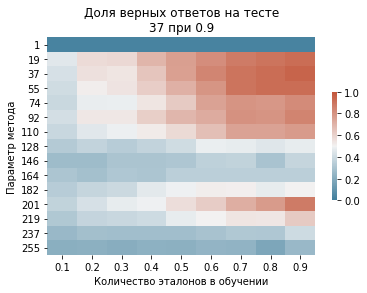

1 1.0 0.9 4 4


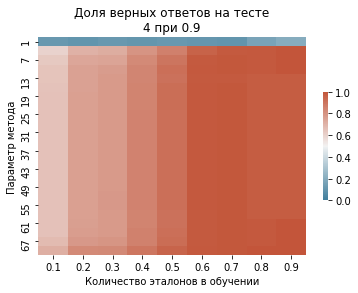

2 1.0 0.9 4 4


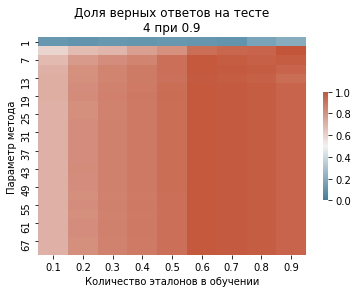

3 0.96875 0.6 0.17 0.17


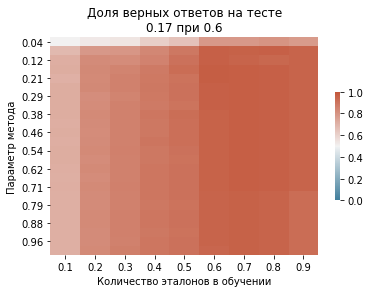

4 0.8916666666666667 0.7 4 4


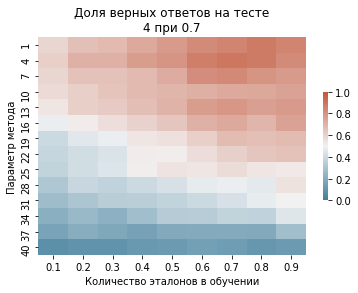

In [171]:
types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]
parameters = [TypeParams.HIST, TypeParams.DFT, TypeParams.DCT, TypeParams.SCALE, TypeParams.GRAD]
train_sizes = [i/10 for i in range(1, 10)]

best_clfs = []
best_train_sizes_per_clf = {}
best_params = {}


# каждый тип по 1.5 минуты в среднем = около 6 минут

for type, params in zip(types, parameters):
    test_score = []
    clfs = []

    for param in params:
        temp = []
        for train_size in train_sizes:
            clf = Classifier(type, CLASSCOUNT, 10)
            clf.fit(DIR, all_files_names, train_size, param)
            clfs.append(clf)
            temp.append(clf.test_score)
        test_score.append(temp)
    
    test_score = np.array(test_score)
    # print(type, test_score.shape, test_score)
    max_score_index = np.argmax(test_score)
    max_score = test_score.ravel()[max_score_index]
    best_clfs.append(clfs[max_score_index])
    best_train_sizes_per_clf[type] = train_sizes[max_score_index%len(train_sizes)]
    best_params[type] = params[max_score_index//len(train_sizes)]
    
    print(type, max_score, best_train_sizes_per_clf[type], best_params[type], best_clfs[type].param)


    fig, ax = plt.subplots()
    df_cm = pd.DataFrame(test_score, index = params, columns = train_sizes)
    ax = sns.heatmap(df_cm, vmin=0, vmax=1, cbar_kws={"shrink": .5}, 
                        cmap=sns.diverging_palette(230, 20, as_cmap=True))
    ax.set(ylabel='Параметр метода', xlabel='Количество эталонов в обучении',
            title=f'Доля верных ответов на тесте\n{best_params[type]} при {best_train_sizes_per_clf[type]}')

    # canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea.
    # canvas.draw()

    plt.show()

    # toolbar = NavigationToolbar2Tk(canvas, root)
    # toolbar.update()
    # canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)




In [165]:
tt = np.array(best_clfs[1].test_names)
tt[inds[:2]]

array(['./ORL/renamed/2_10.jpg', './ORL/renamed/3_10.jpg'], dtype='<U23')

На всем тестовом наборе: 0.95
[1.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.9523809523809523, 0.9545454545454546, 0.9565217391304348, 0.9583333333333334, 0.96, 0.9615384615384616, 0.9629629629629629, 0.9642857142857143, 0.9655172413793104, 0.9666666666666667, 0.967741935483871, 0.96875, 0.9696969696969697, 0.9705882352941176, 0.9714285714285714, 0.9444444444444444, 0.9459459459459459, 0.9473684210526315, 0.9487179487179487]


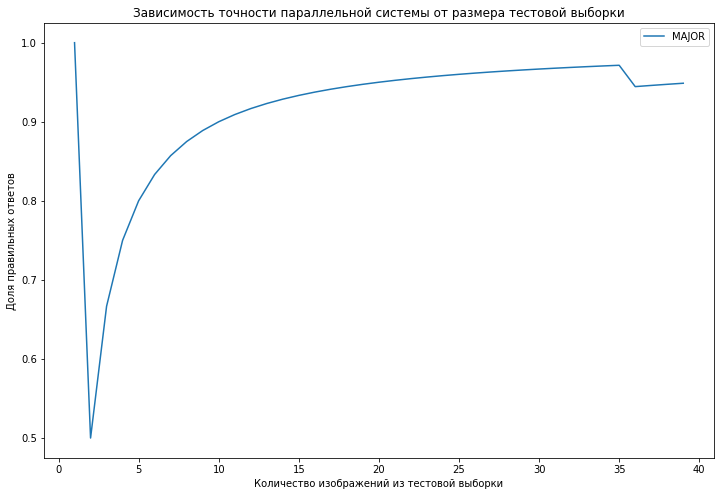

На всем тестовом наборе: 1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


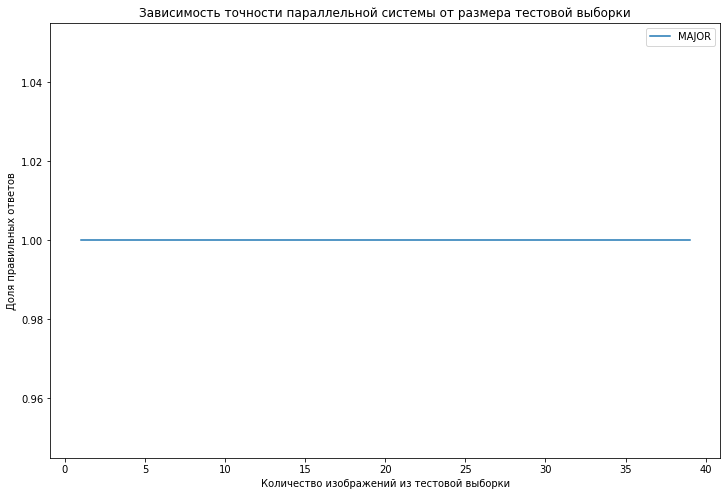

На всем тестовом наборе: 1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


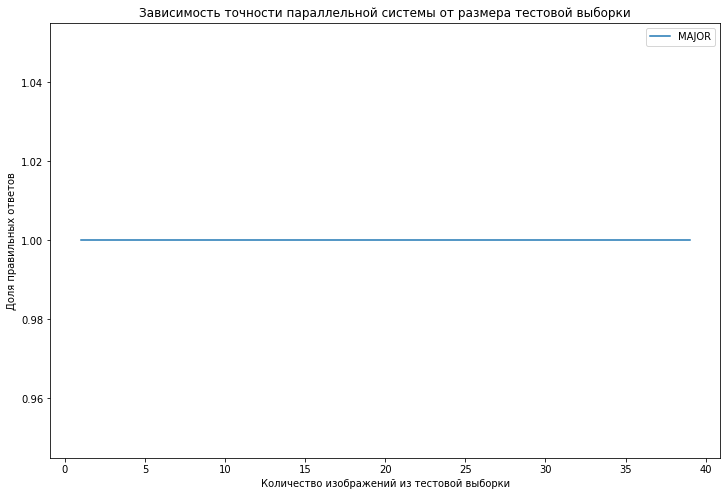

На всем тестовом наборе: 0.96875
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9841269841269841, 0.984375, 0.9846153846153847, 0.9848484848484849, 0.9850746268656716, 0.9852941176470589, 0.9855072463768116, 0.9857142857142858, 0.9859154929577465, 0.9861111111111112, 0.9863013698630136, 0.9864864864864865, 0.9866666666666667, 0.9868421052631579, 0.987012987012987, 0.9871794871794872, 0.9873417721518988, 0.9875, 0.9876543209876543, 0.9878048780487805, 0.9879518072289156, 0.9761904761904762, 0.9764705882352941, 0.9767441860465116, 0.9770114942528736, 0.9772727272727273, 0.9775280898876404, 0.9777777777777777, 0.978021978021978, 0.9782608695652174, 0.978494623655914, 0.9787234042553191, 0.9789473684210527, 0.9791666666666666, 0

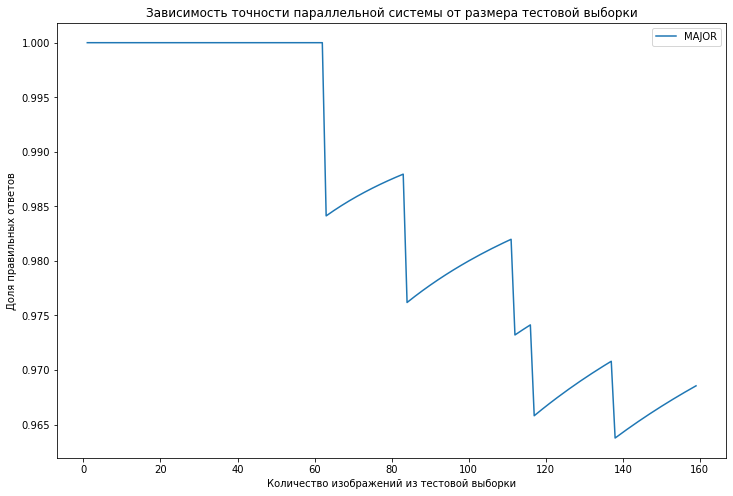

На всем тестовом наборе: 0.8916666666666667
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.8333333333333334, 0.8461538461538461, 0.8571428571428571, 0.8666666666666667, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8947368421052632, 0.9, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.8888888888888888, 0.8928571428571429, 0.896551724137931, 0.9, 0.8709677419354839, 0.875, 0.8787878787878788, 0.8823529411764706, 0.8857142857142857, 0.8888888888888888, 0.8918918918918919, 0.8947368421052632, 0.8974358974358975, 0.875, 0.8536585365853658, 0.8571428571428571, 0.8604651162790697, 0.8636363636363636, 0.8666666666666667, 0.8695652173913043, 0.8723404255319149, 0.8541666666666666, 0.8571428571428571, 0.86, 0.8431372549019608, 0.8461538461538461, 0.8490566037735849, 0.8518518518518519, 0.8363636363636363, 0.8392857142857143, 0.8421052631578947, 0.8448275862068966, 0.847457627118644, 0.85, 0.8524590163934426, 0.854838709

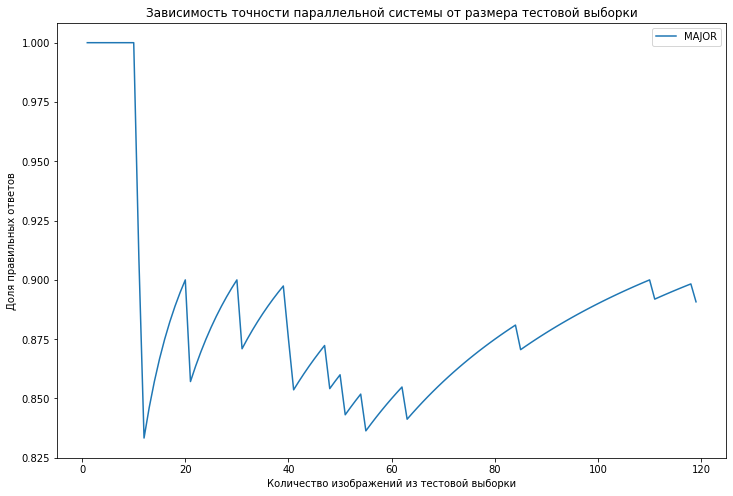

In [177]:
from sklearn.model_selection import train_test_split

for clf in best_clfs:
    scores = []
    print('На всем тестовом наборе:', clf.test_score)

    inds = []
    for i in range(1, clf.test_labels.shape[0]+1):
        tmp = None
        while tmp in inds:
            tmp = np.random.randint(low=0, high=clf.test_labels.shape[0]-1)
        inds.append(tmp)
    inds = inds[1:]

    sizes = []
    for i in range(1, len(inds)+1):
        tmp = np.array(clf.test_names)
        test_imgs = np.array([cv2.imread(i, 0) for i in tmp[inds[:i]]])
        test_labels = np.array(clf.test_labels[inds[:i]])
        scores.append(clf.score_without_test(test_imgs, test_labels))
        sizes.append(test_imgs.shape[0])
                
    print(scores)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(sizes, scores, label=f'{clf.name}')
    ax.set(xlabel='Количество изображений из тестовой выборки', 
            ylabel='Доля правильных ответов', 
            title='Зависимость точности параллельной системы от размера тестовой выборки')
    ax.legend()
    plt.show()

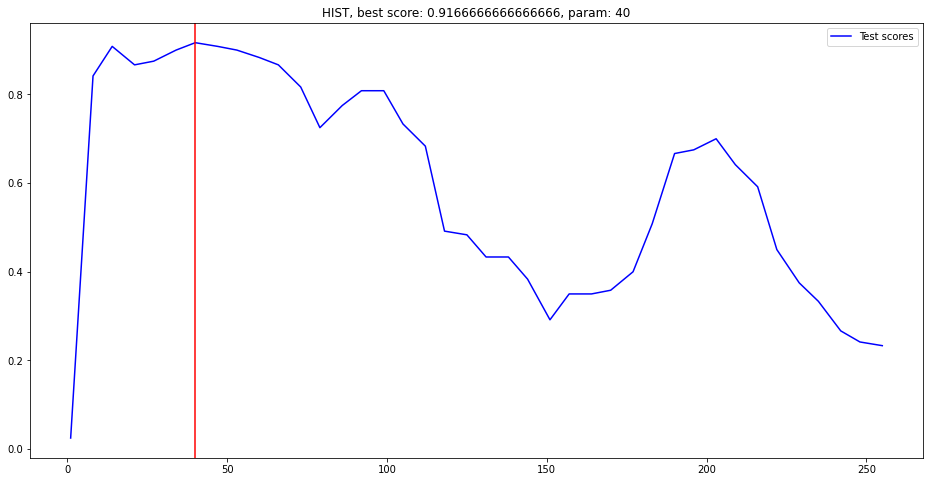

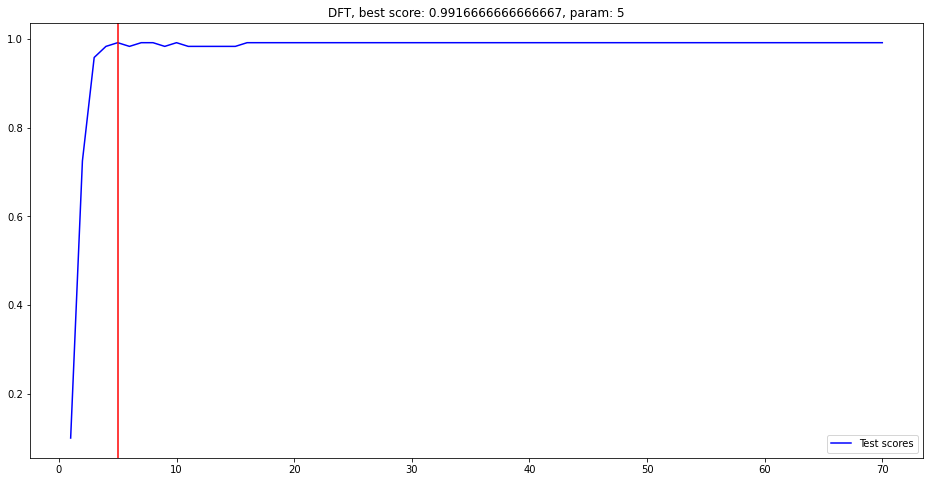

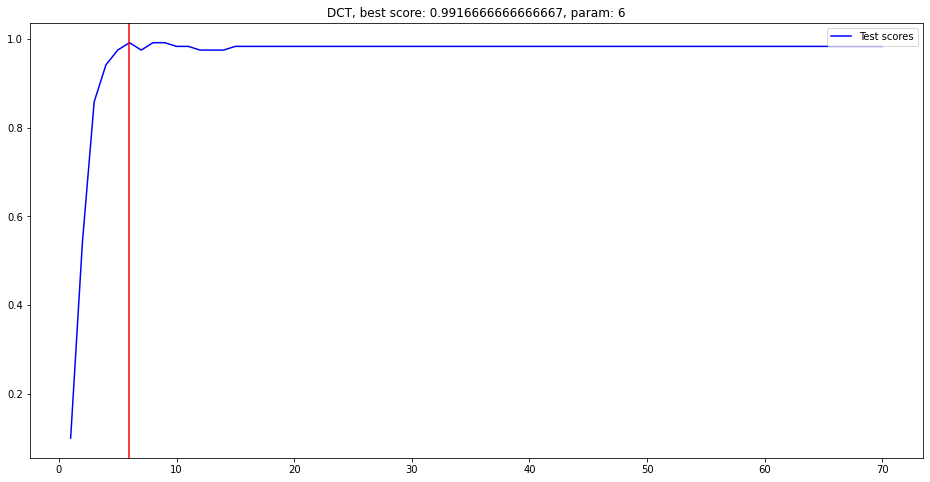

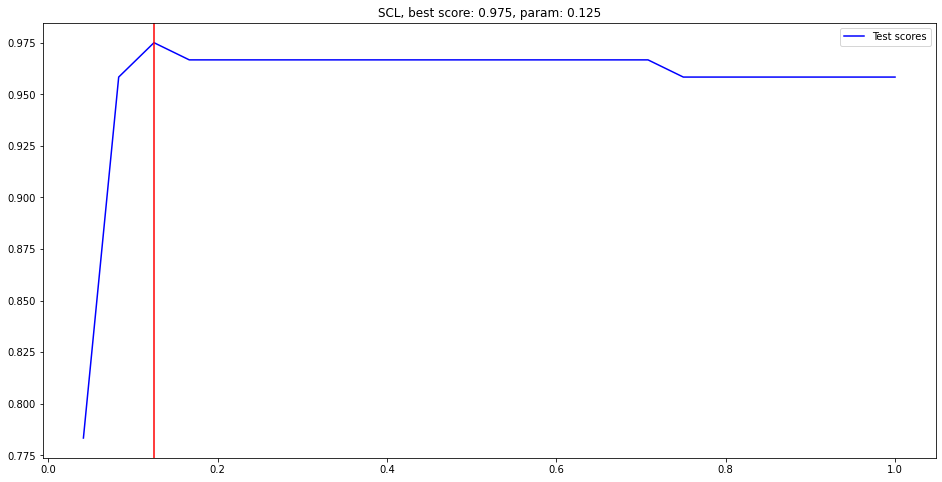

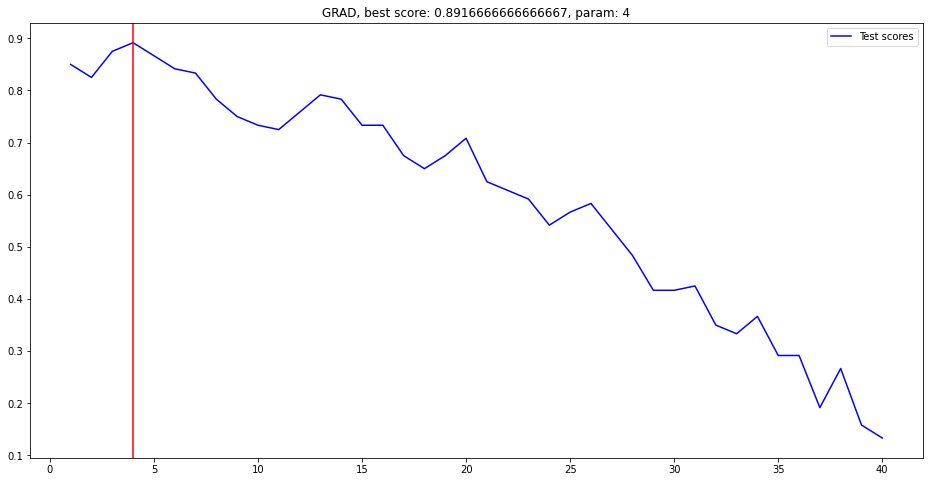

In [11]:
types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]
parameters = [TypeParams.HIST, TypeParams.DFT, TypeParams.DCT, TypeParams.SCALE, TypeParams.GRAD]
train_size = 0.7

best_params = {}

for type, params in zip(types, parameters):
    title = ''
    test_score = []
    for param in params:
        clf = Classifier(type, CLASSCOUNT, 10)
        clf.fit(DIR, all_files_names, train_size, param)
        test_score.append(clf.test_score)
        title = clf.name
    
    max_score_index = np.argmax(np.array(test_score))
    max_score = test_score[max_score_index]
    max_score_param = params[max_score_index]
    best_params[type] = max_score_param
    
    plt.figure(figsize=(16, 8)) 

    plt.plot(params, test_score, color='blue', label='Test scores')
    plt.axvline(max_score_param, color='red')
    plt.legend()
    plt.title(f'{title}, best score: {max_score}, param: {max_score_param}')
    plt.show()
        

In [12]:
best_params

{0: 40, 1: 5, 2: 6, 3: 0.125, 4: 4}

In [27]:
# types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]

# scores = {i:[] for i in range(len(types))}

# for type, param in zip(types, best_params):
#     clf = Classifier(type, CLASSCOUNT, 10)
#     clf.fit(DIR, all_files_names, 0.7, best_params[param])
#     print(clf.name)
#     print('\tИсходные изображения:')
#     scores[type].append(clf.score('./ORL/renamed/'))
#     print('\tС масками:')
#     scores[type].append(clf.score('./ORL/renamed/masks/'))
#     print('\tНизкой степени деидентификации:')
#     scores[type].append(clf.score('./ORL/renamed/cloaked/'))
#     print()

# print(scores)

### Подбор оптимального размера выборки для полученных на предыдущем шаге оптимальных параметров

#### 1) оптимальное количество эталонов

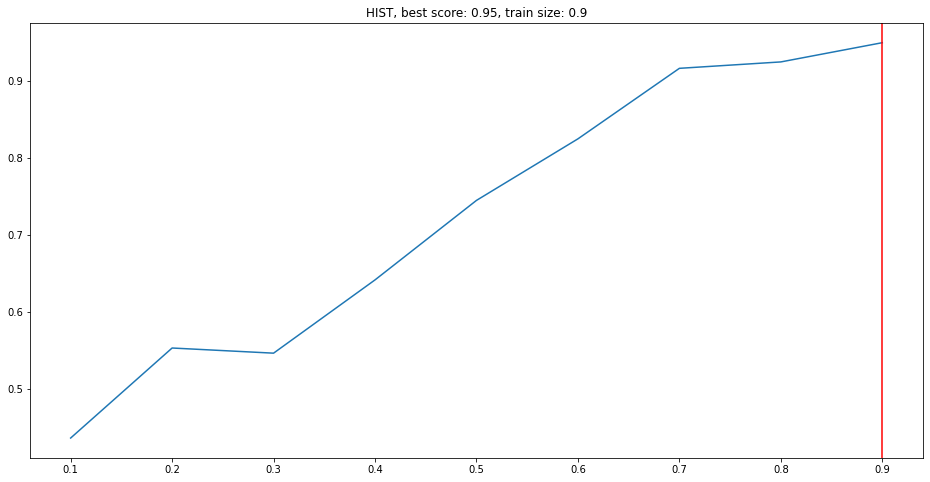

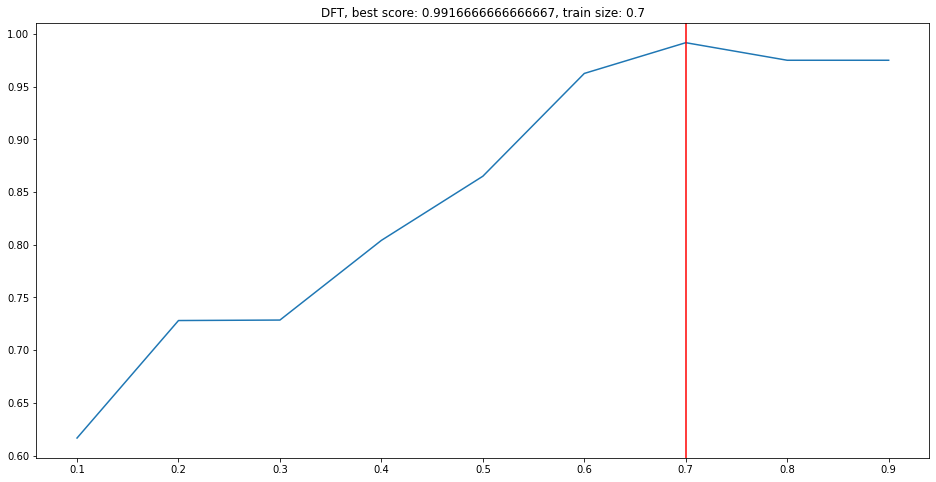

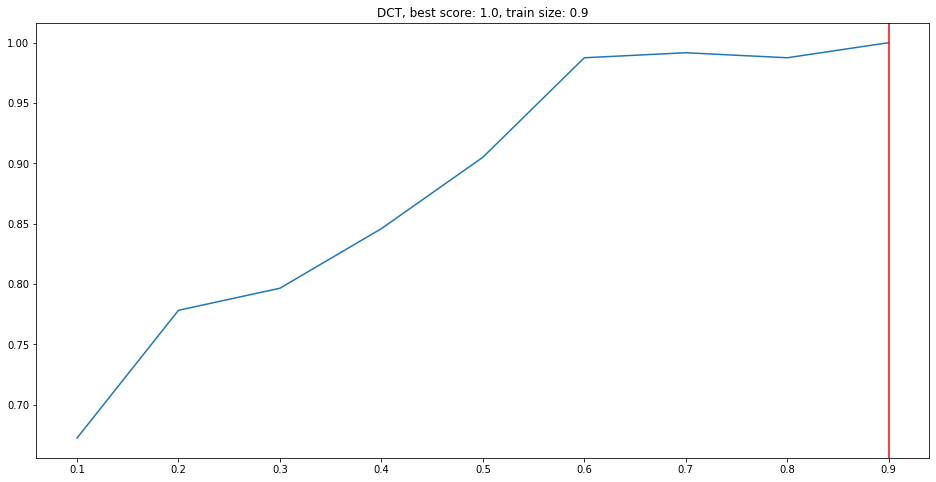

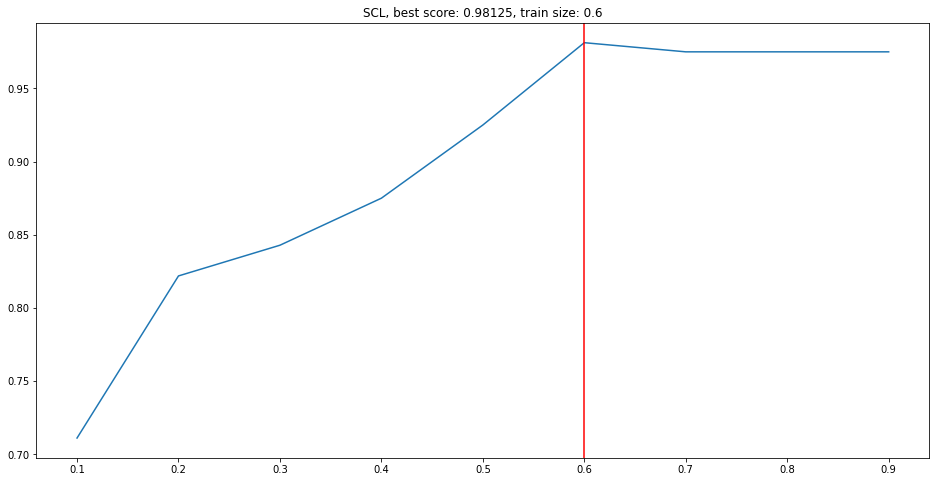

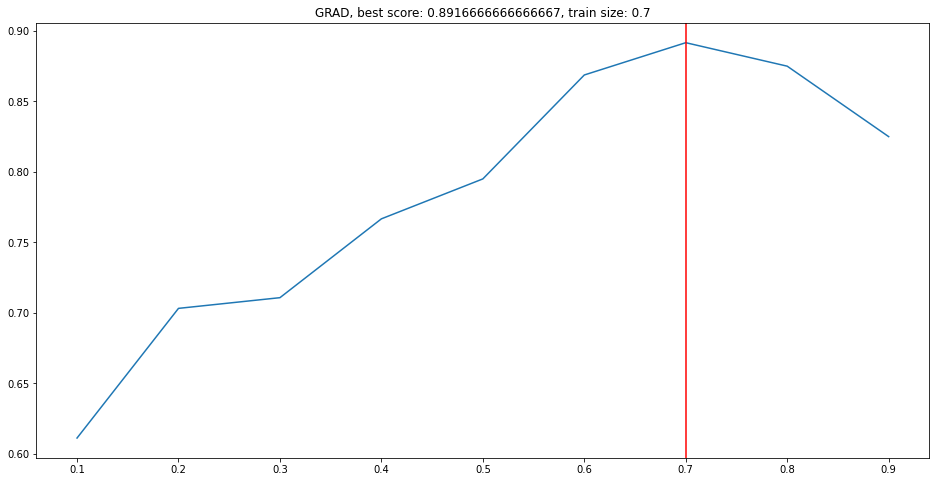

In [13]:
types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]
# parameters = [TypeParams.HIST, TypeParams.DFT, TypeParams.DCT, TypeParams.SCALE, TypeParams.GRAD]
train_sizes = [i/10 for i in range(1, 10)]

best_train_sizes_per_clf = {}

for type in types:
    title = ''
    score = []
    for train_size in train_sizes:
        clf = Classifier(type, CLASSCOUNT, 10)
        clf.fit(DIR, all_files_names, train_size, best_params[type])
        score.append(clf.test_score)
        title = clf.name
    
    max_score_index = np.argmax(np.array(score))
    max_score = score[max_score_index]
    max_score_param = train_sizes[max_score_index]
    best_train_sizes_per_clf[type] = max_score_param
    
    plt.figure(figsize=(16, 8)) 
    plt.plot(train_sizes, score)
    plt.axvline(max_score_param, color='red')
    plt.title(f'{title}, best score: {max_score}, train size: {max_score_param}')
    plt.show()
        

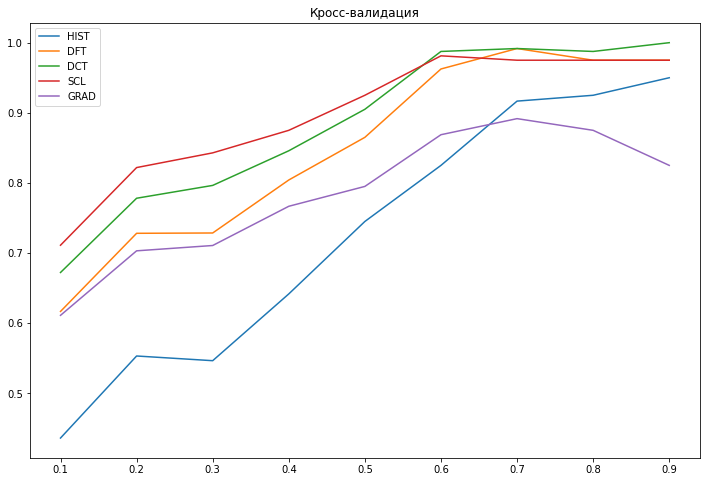

In [14]:
best_train_sizes_per_clf = {}

plt.figure(figsize=(12, 8)) 

for type in types:
    title = ''
    score = []
    for train_size in train_sizes:
        clf = Classifier(type, CLASSCOUNT, 10)
        clf.fit(DIR, all_files_names, train_size, best_params[type])
        score.append(clf.test_score)
        title = clf.name
    
    max_score_index = np.argmax(np.array(score))
    max_score = score[max_score_index]
    max_score_param = train_sizes[max_score_index]
    best_train_sizes_per_clf[type] = max_score_param
    
    
    plt.plot(train_sizes, score, label=f'{clf.name}')
    # plt.axvline(max_score_param, color='red')

plt.title('Кросс-валидация')
plt.legend()
plt.show()
        

In [110]:
tmp = pd.DataFrame(all_files_names)
tmp.columns = ['filename']
tmp['label'] = all_labels
tmp['number'] = tmp.filename.apply(lambda st: int(st[st.find('_')+1:st.find('.')]))

tmp

filename  label  number
0      1_1.jpg      1       1
1      1_2.jpg      1       2
2      1_3.jpg      1       3
3      1_4.jpg      1       4
4      1_5.jpg      1       5
..         ...    ...     ...
395   40_6.jpg     40       6
396   40_7.jpg     40       7
397   40_8.jpg     40       8
398   40_9.jpg     40       9
399  40_10.jpg     40      10

[400 rows x 3 columns]

In [94]:
best_train_sizes_per_clf

{0: 0.9, 1: 0.9, 2: 0.9, 3: 0.6, 4: 0.7}

In [ ]:
from sklearn.model_selection import train_test_split

scores = []

x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, train_size=0.7) #stratify?
major = MajorClassifier(best_params)
major.fit_without_test(x_train, y_train)
print('На всем тестовом наборе:', major.score_without_test(x_test, y_test))

inds = []
for i in range(1, x_test.shape[0]+1):
    tmp = None
    while tmp in inds:
        tmp = np.random.randint(low=0, high=x_test.shape[0]-1)
    inds.append(tmp)
inds = inds[1:]

sizes = []
for i in range(1, len(inds)+1):
    test_imgs = x_test[inds[:i], :]
    test_labels = y_test[inds[:i]]
    scores.append(major.score_without_test(test_imgs, test_labels))
    sizes.append(test_imgs.shape[0])
            
print(scores)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(sizes, scores, label='MAJOR')
ax.set(xlabel='Количество изображений из тестовой выборки', 
        ylabel='Доля правильных ответов', 
        title='Зависимость точности параллельной системы от размера тестовой выборки')
ax.legend()
plt.show()

#### 2) оптимальное количество изображений

In [10]:
class MajorClassifierFitted:
    def __init__(self, clfs, train_sizes, params):
        self.params = params
        self.minors = clfs
        self.train_sizes = train_sizes
        self.name = 'MAJOR'

    def detect(self, path_to_img):
        votes = []
        for minor in self.minors:
            votes.append(minor.detect(path_to_img))
        # print(votes)
        return np.argmax(np.bincount(np.array(votes)))
    
    def score_without_test(self, images, labels):
        def detect_without_test(image):
            votes = []
            for minor in self.minors:
                votes.append(minor.detect_without_test(image))
            return np.argmax(np.bincount(np.array(votes)))

        predicted = [detect_without_test(image) for image in images]
        return np.sum(predicted == labels)/labels.shape[0]

In [80]:
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, train_size=0.66, stratify=all_labels)
major = MajorClassifier(best_params)
major.fit_without_test(x_train, y_train)
print(major.score_without_test(x_test, y_test))

0.9779411764705882


In [21]:
best_params

{0: 34, 1: 4, 2: 4, 3: 0.125, 4: 4}

In [18]:
all_images[3, :].shape

(80, 70)

In [62]:
all_images[inds[:3], :]

3

На всем тестовом наборе: 0.9833333333333333
[1.0, 1.0, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.9523809523809523, 0.9545454545454546, 0.9565217391304348, 0.9583333333333334, 0.96, 0.9615384615384616, 0.9629629629629629, 0.9642857142857143, 0.9655172413793104, 0.9666666666666667, 0.967741935483871, 0.96875, 0.9696969696969697, 0.9705882352941176, 0.9714285714285714, 0.9722222222222222, 0.972972972972973, 0.9736842105263158, 0.9743589743589743, 0.975, 0.975609756097561, 0.9761904761904762, 0.9767441860465116, 0.9772727272727273, 0.9777777777777777, 0.9782608695652174, 0.9787234042553191, 0.9791666666666666, 0.9591836734693877, 0.96, 0.9607843137254902, 0.9615384615384616, 0.9622641509433962, 0.9629629629629629, 0.9636363636363636, 0.9642857142857143, 0.9

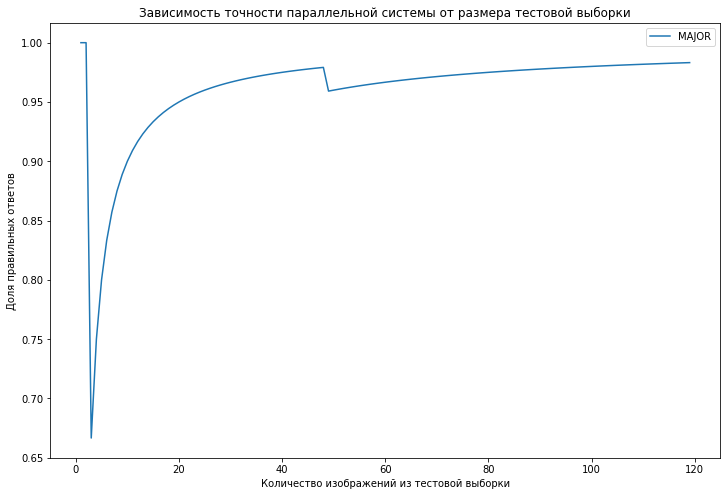

In [90]:
from sklearn.model_selection import train_test_split

best_score_for_test_size = None
best_test_size = None
best_major_clf = None

scores = []

x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, train_size=0.7) #stratify?
major = MajorClassifier(best_params)
major.fit_without_test(x_train, y_train)
print('На всем тестовом наборе:', major.score_without_test(x_test, y_test))

inds = []
for i in range(1, x_test.shape[0]+1):
    tmp = None
    while tmp in inds:
        tmp = np.random.randint(low=0, high=x_test.shape[0]-1)
    inds.append(tmp)
inds = inds[1:]

sizes = []
for i in range(1, len(inds)+1):
    test_imgs = x_test[inds[:i], :]
    test_labels = y_test[inds[:i]]
    scores.append(major.score_without_test(test_imgs, test_labels))
    sizes.append(test_imgs.shape[0])
            
print(scores)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(sizes, scores, label='MAJOR')
ax.set(xlabel='Количество изображений из тестовой выборки', 
        ylabel='Доля правильных ответов', 
        title='Зависимость точности параллельной системы от размера тестовой выборки')
ax.legend()
plt.show()

### Создание классификатора, использующего систему голосования минорных классификаторов

In [16]:
print('Класификаторы: ', 'HIST', 'DFT', 'DCT', 'SCALE', 'GRAD')
print('Лучшие параметры: ', best_params)
print('Лучший размер обучающего набора: ', best_train_sizes_per_clf)

Класификаторы:  HIST DFT DCT SCALE GRAD
Лучшие параметры:  {0: 40, 1: 5, 2: 6, 3: 0.125, 4: 4}
Лучший размер обучающего набора:  {0: 0.9, 1: 0.7, 2: 0.9, 3: 0.6, 4: 0.7}


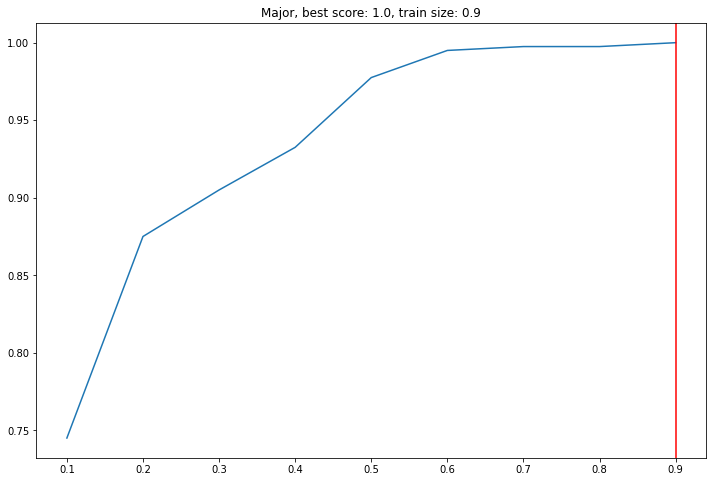

In [17]:
train_sizes = [i/10 for i in range(1, 10)]
test_scores = []
best_train_size_for_major = None

for train_size in train_sizes:
    clf = MajorClassifier(best_params)
    clf.fit(DIR, all_files_names, {i:train_size for i in range(len(types))})
    test_scores.append(clf.score('./ORL/renamed/'))
    
max_score_index = np.argmax(np.array(test_scores))
max_score = test_scores[max_score_index]
max_score_param = train_sizes[max_score_index]

plt.figure(figsize=(12, 8)) 
plt.plot(train_sizes, test_scores)
plt.axvline(max_score_param, color='red')
plt.title(f'Major, best score: {max_score}, train size: {max_score_param}')
plt.show()

best_train_size_for_major = max_score_param


In [18]:
def plot_ratio(paths:str, train_sizes, train_size_for_major, params):
    clfs = []
    types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]

    for type, param in zip(types, params):
        clf = Classifier(type, CLASSCOUNT, 10)
        clf.fit(DIR, all_files_names, train_sizes[type], params[param])
        clfs.append(clf)

    clf = MajorClassifier(params)
    clf.fit(DIR, all_files_names, {i:train_size_for_major for i in range(len(types))})
    clfs.append(clf)

    scores = [[] for path in paths]

    for i, path_to_img in enumerate(paths):
        for clf in clfs:
            scores[i].append(clf.score(path_to_img))

    labels = ['HIST', 'DFT', 'DCT', 'SCALE', 'GRAD', 'MAJOR']
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(16, 8))
    plt.title('Сравнение работы классификаторов на разных изображениях')
    plt.bar(x-width, scores[0], width, label='Исходные изображения, 400 шт')
    plt.bar(x, scores[1], width, label='С масками, 388 шт.')
    plt.bar(x+width, scores[2], width, label='Низкая степень деидентификации')
    
    plt.xticks(x, labels)
    plt.xlabel("Classificators")
    plt.ylabel("Scores")

    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left")
    plt.show()

def plot_2_ratio(paths:str, train_sizes, train_size_for_major, params):
    clfs = []
    types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]

    for type, param in zip(types, params):
        clf = Classifier(type, CLASSCOUNT, 10)
        clf.fit(DIR, all_files_names, train_sizes[type], params[param])
        clfs.append(clf)

    clf = MajorClassifier(params)
    clf.fit(DIR, all_files_names, {i:train_size_for_major for i in range(len(types))})
    clfs.append(clf)

    scores = [[] for path in paths]

    for i, path_to_img in enumerate(paths):
        for clf in clfs:
            scores[i].append(clf.score(path_to_img))

    labels = ['HIST', 'DFT', 'DCT', 'SCALE', 'GRAD', 'MAJOR']
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(8, 8))
    plt.title('Сравнение работы классификаторов на разных изображениях')
    # plt.bar(x-width/2, scores[0], width, label='Исходные изображения, 400 шт')
    # plt.bar(x+width/2, scores[1], width, label='Низкая степень деидентификации')
    plt.scatter(labels, scores[0], label='Исходные изображения, 400 шт')
    plt.scatter(labels, scores[1], label='Низкая степень деидентификации')
    
    plt.xticks(x, labels)
    plt.xlabel("Classificators")
    plt.ylabel("Scores")

    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left")
    plt.show()


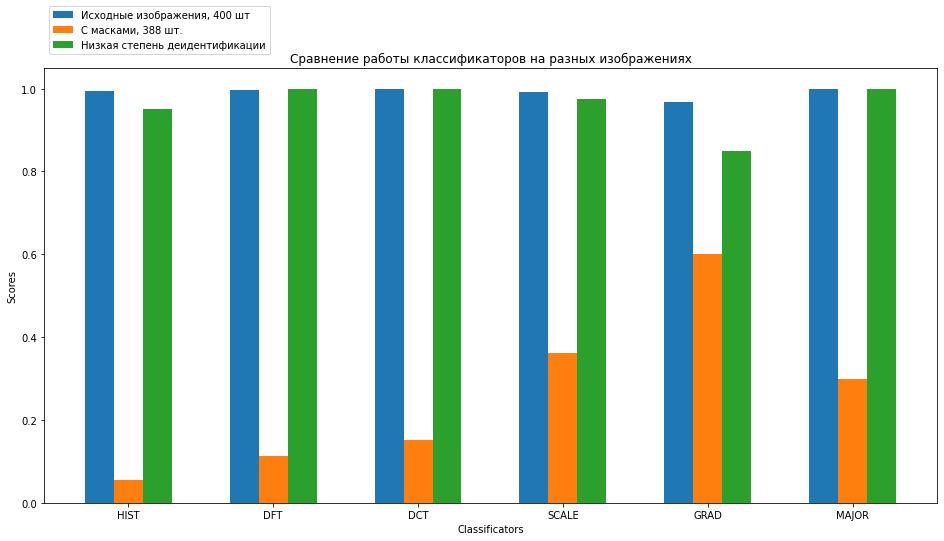

In [19]:
train_sizes = best_train_sizes_per_clf
paths = ['./ORL/renamed/', './ORL/renamed/masks/', './ORL/renamed/cloaked/']

plot_ratio(paths, train_sizes, best_train_size_for_major, best_params)

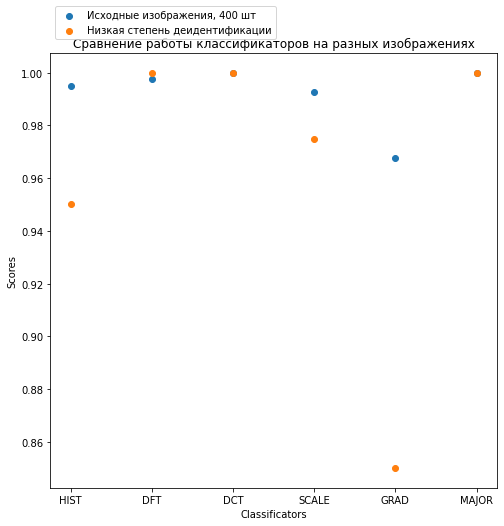

In [20]:
plot_2_ratio(['./ORL/renamed/', './ORL/renamed/cloaked/'], train_sizes, best_train_size_for_major, best_params)

In [21]:
clf = MajorClassifier(best_params)
clf.fit(DIR, all_files_names, best_train_sizes_per_clf)

# clf.detect('./ORL/renamed/1_1.jpg')
# clf.detect('./jpg/images/1_1_cloaked.jpg')

clf.detect('./ORL/renamed/masks/14_10-with-mask.jpg')
# clf.detect('./ORL/renamed/31_8.jpg')

# print(clf.score('./ORL/renamed/cloaked/'))

# clf.fit(DIR, all_files_names, {i:best_train_size_for_major for i in range(len(types))})
# print(clf.score('./ORL/renamed/cloaked/'))

3

In [22]:
types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]

for type, param in zip(types, best_params):
    clf = Classifier(type, CLASSCOUNT, 10)
    clf.fit(DIR, all_files_names, 0.7, best_params[param])
    print(clf.name)
    print('\tИсходные изображения:', clf.score('./ORL/renamed/'))
    print('\tС масками:', clf.score('./ORL/renamed/masks/'))
    print('\tНизкой степени деидентификации:', clf.score('./ORL/renamed/cloaked/'))
    print()

HIST
	Исходные изображения: 0.975
	С масками: 0.04381443298969072
	Низкой степени деидентификации: 0.95

DFT
	Исходные изображения: 0.9975
	С масками: 0.1134020618556701
	Низкой степени деидентификации: 1.0

DCT
	Исходные изображения: 0.9975
	С масками: 0.14690721649484537
	Низкой степени деидентификации: 1.0

SCL
	Исходные изображения: 0.9925
	С масками: 0.3788659793814433
	Низкой степени деидентификации: 0.975

GRAD
	Исходные изображения: 0.9675
	С масками: 0.6005154639175257
	Низкой степени деидентификации: 0.85



In [23]:
print('До подбора оптимальных параметров и размера обучающей выборки')
types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]
path = './ORL/renamed/'

parameters = [55, 5, 5, 0.5, 5]

for i, type in enumerate(types):
    clf = Classifier(type, CLASSCOUNT, 10)
    clf.fit(DIR, all_files_names, 0.7, parameters[i])
    print(clf.name, clf.score(path))

clf = MajorClassifier({i:parameters[i] for i in range(len(types))})
clf.fit(DIR, all_files_names, {i:0.7 for i in range(len(types))})
print(clf.name, clf.score(path))

print('___________')
print('С оптимальными параметрами и размером обучающей выборки')

parameters = best_params

for i, type in enumerate(types):
    clf = Classifier(type, CLASSCOUNT, 10)
    clf.fit(DIR, all_files_names, best_train_sizes_per_clf[i], parameters[i])
    print(clf.name, clf.score(path))

clf = MajorClassifier(parameters)
clf.fit(DIR, all_files_names, {i:0.9 for i in range(len(types))})
print(clf.name, clf.score(path))

До подбора оптимальных параметров и размера обучающей выборки
HIST 0.97
DFT 0.9975
DCT 0.9925
SCL 0.99
GRAD 0.96
MAJOR 0.9975
___________
С оптимальными параметрами и размером обучающей выборки
HIST 0.995
DFT 0.9975
DCT 1.0
SCL 0.9925
GRAD 0.9675
MAJOR 1.0


In [35]:
print('\tМАСКИ')
print('До подбора оптимальных параметров и размера обучающей выборки')
types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]
path = './ORL/renamed/masks/'

parameters = [55, 5, 5, 0.5, 5]

for i, type in enumerate(types):
    clf = Classifier(type, CLASSCOUNT, 10)
    clf.fit(DIR, all_files_names, 0.7, parameters[i])
    print(clf.name, clf.score(path))

clf = MajorClassifier({i:parameters[i] for i in range(len(types))})
clf.fit(DIR, all_files_names, {i:0.7 for i in range(len(types))})
print(clf.name, clf.score(path))

print('___________')
print('С оптимальными параметрами и размером обучающей выборки')

parameters = best_params

for i, type in enumerate(types):
    clf = Classifier(type, CLASSCOUNT, 10)
    clf.fit(DIR, all_files_names, best_train_sizes_per_clf[i], parameters[i])
    print(clf.name, clf.score(path))

clf = MajorClassifier(parameters)
clf.fit(DIR, all_files_names, {i:0.9 for i in range(len(types))})
print(clf.name, clf.score(path))

	МАСКИ
До подбора оптимальных параметров и размера обучающей выборки
HIST 0.06958762886597938
DFT 0.1134020618556701
DCT 0.14690721649484537
SCL 0.6288659793814433
GRAD 0.5412371134020618
MAJOR 0.36855670103092786
___________
С оптимальными параметрами и размером обучающей выборки
HIST 0.05412371134020619
DFT 0.1134020618556701
DCT 0.15206185567010308
SCL 0.36082474226804123
GRAD 0.6005154639175257
MAJOR 0.29896907216494845


### Наглядное представление работы классификаторов

In [197]:
st = 'C:/Users/Asus/Desktop/учеба/4 курс/Биометрия/ORL/renamed/1_2.jpg'
'.'+st[st.find('/OR'):]

'./ORL/renamed/1_2.jpg'

6 7


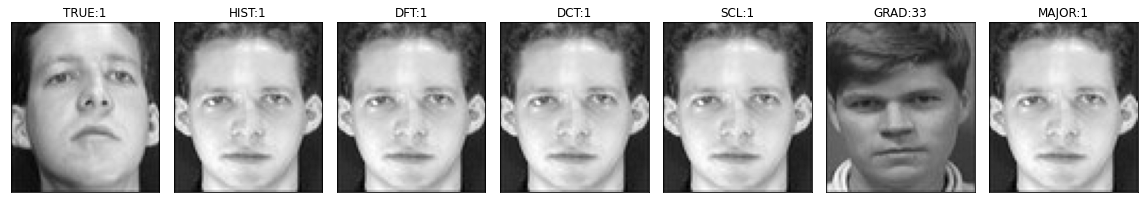

In [211]:
def plot_predicted_labels(path_to_orig:str, clfs:list):
    path_to_orig = '.'+path_to_orig[path_to_orig.find('/OR'):]
    fig, ax = plt.subplots(nrows=1, ncols=len(best_clfs)+2, figsize=(16, 8))
    cols = len(clfs)

    
    print(len(clfs), len(ax))

    for i in range(cols+1):
        if i==0:
            image = cv2.imread(path_to_orig, 0)
            title = f'TRUE:{clfs[1].get_true_label(path_to_orig)}'
        else:
            label = clfs[i-1].detect(path_to_orig)
            image = cv2.imread(LabelFace[label], 0)
            title = f'{clfs[i-1].name}:{label}'

        ax[i].set_title(title)
        ax[i].imshow(image, cmap='gray')
        ax[i].set_xticks([]),ax[i].set_yticks([])

    plt.tight_layout()
    plt.show()

plot_predicted_labels('C:/Users/Asus/Desktop/учеба/4 курс/Биометрия/ORL/renamed/1_9.jpg', best_clfs+[major])


TypeError: Image data of dtype object cannot be converted to float

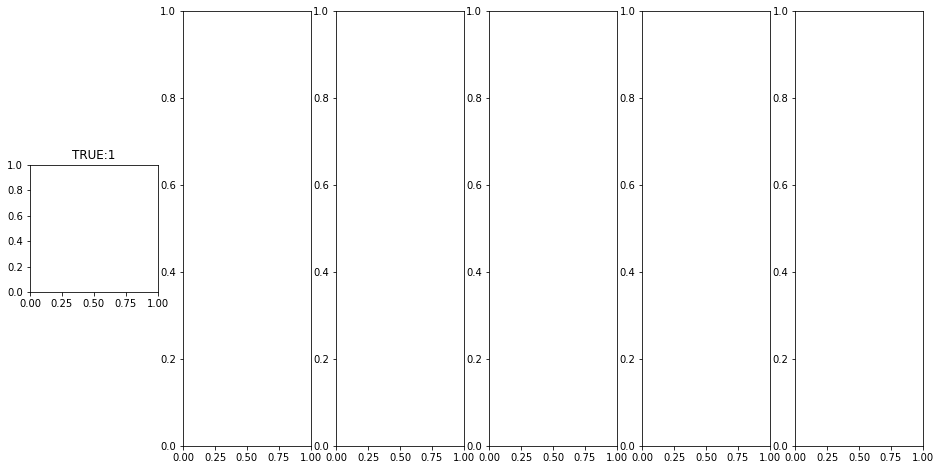

TypeError: Image data of dtype object cannot be converted to float

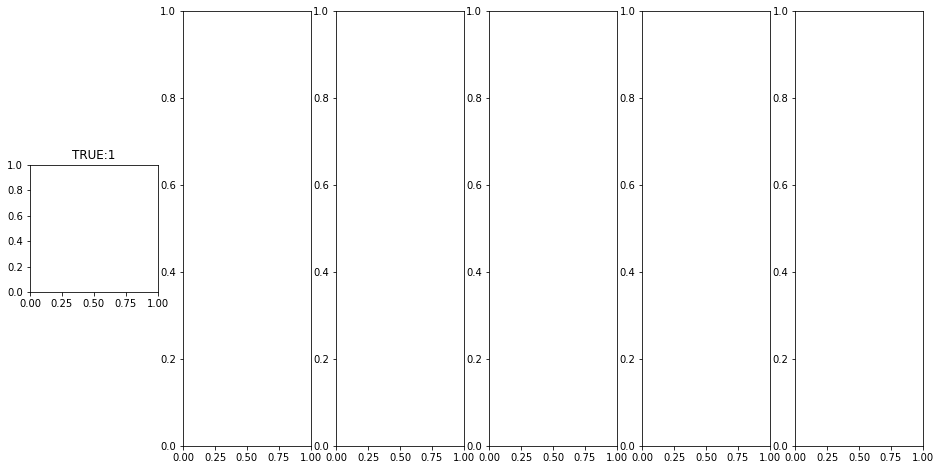

In [188]:
# clfs = []
# types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]

# i = 0
# for type, param in zip(types, best_params):
#     clf = Classifier(type, CLASSCOUNT, 10)
#     clf.fit(DIR, all_files_names, best_train_sizes_per_clf[i], best_params[param])
#     clfs.append(clf)
#     i += 1

# clf = MajorClassifier(best_params)
# # clf.fit(DIR, all_files_names, {i:best_train_size_for_major for i in range(len(types))})
# clf.fit(DIR, all_files_names, best_train_sizes_per_clf)
# clfs.append(clf)

# plot_predicted_labels('./ORL/renamed/31_1.jpg', clfs)
# plot_predicted_labels('./ORL/renamed/masks/31_1-with-mask.jpg', clfs)
# plot_predicted_labels('./ORL/renamed/cloaked/train/31_1_low_cloaked.jpg', clfs)

plot_predicted_labels('C:/Users/Asus/Desktop/учеба/4 курс/Биометрия/ORL/renamed/1_2.jpg', best_clfs+[major])
plot_predicted_labels('./ORL/renamed/5_10.jpg', clfs)
plot_predicted_labels('./ORL/renamed/10_10.jpg', clfs)

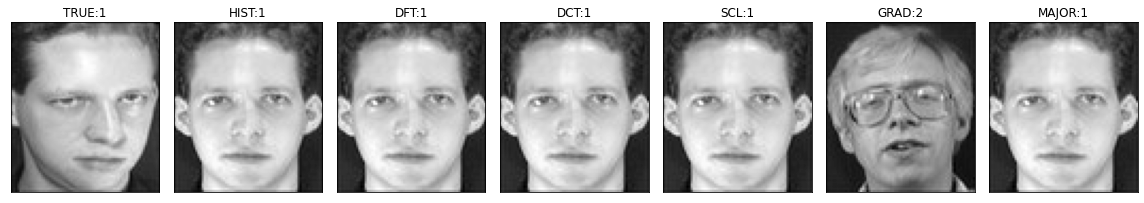

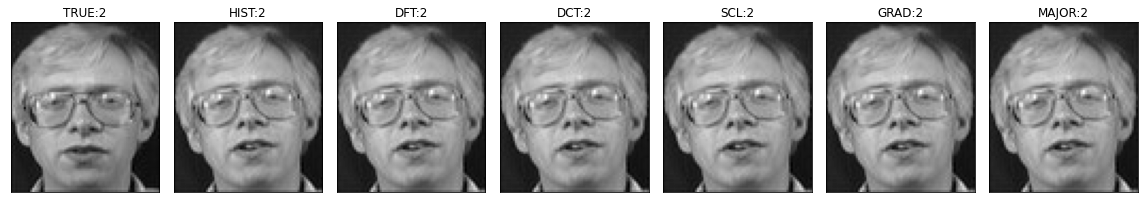

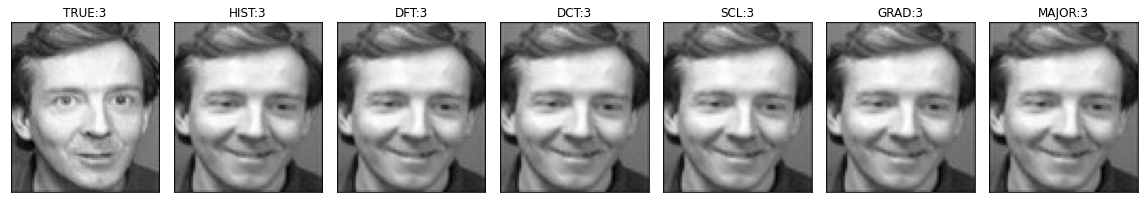

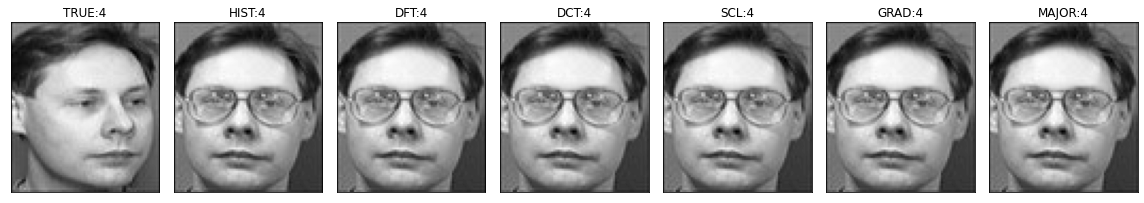

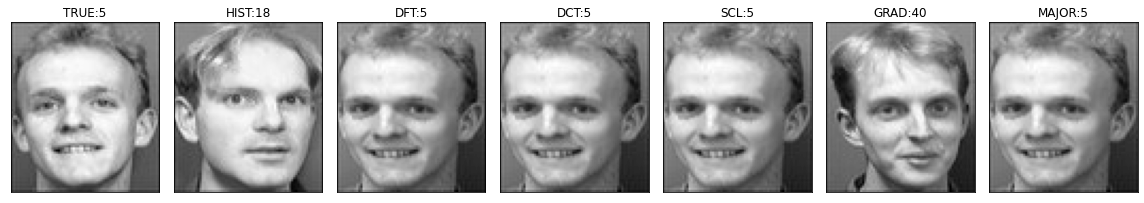

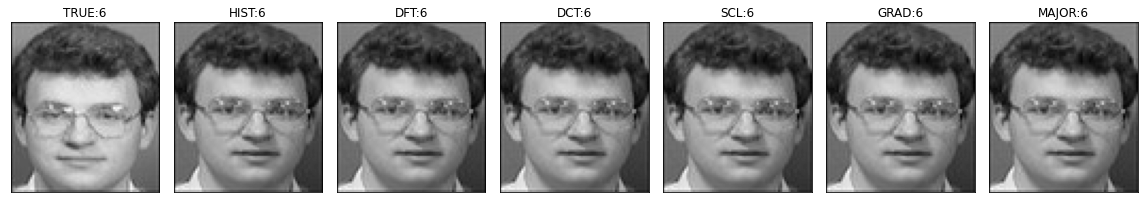

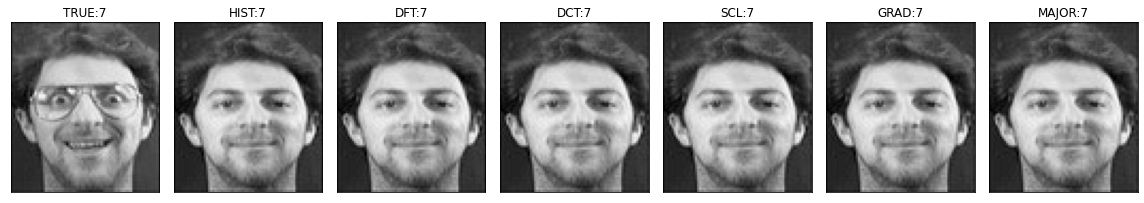

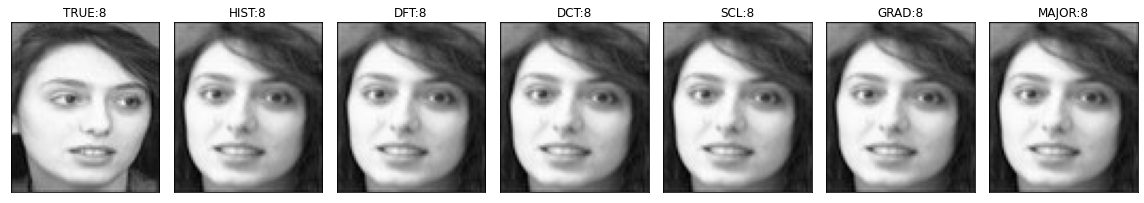

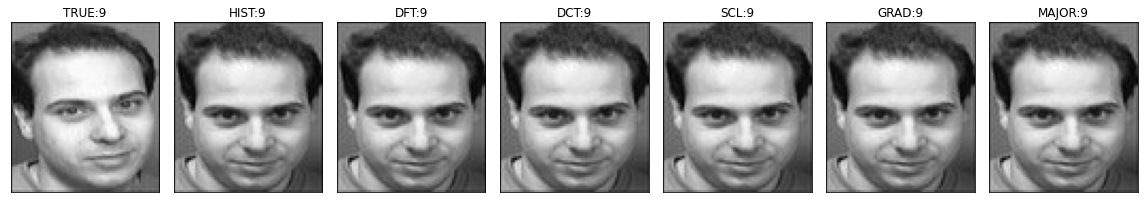

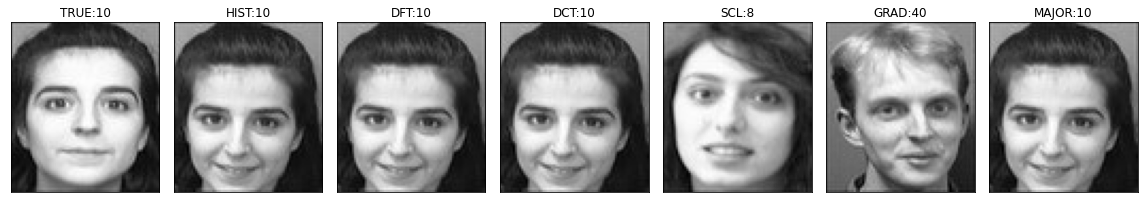

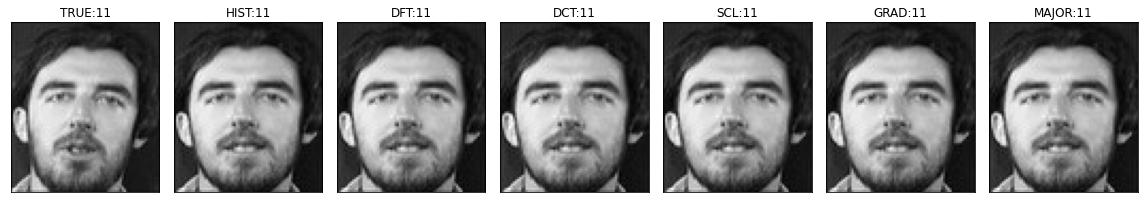

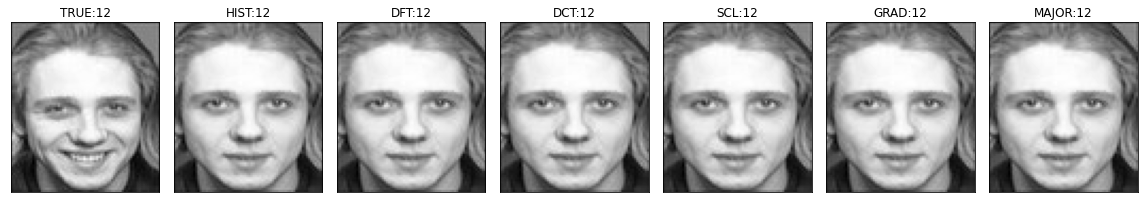

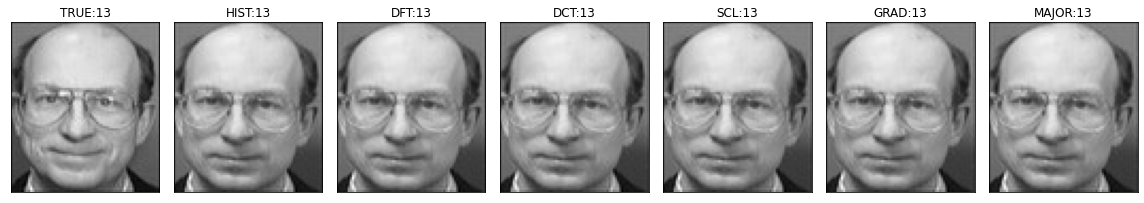

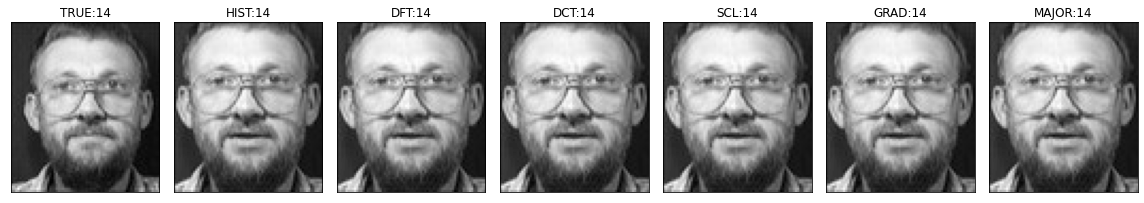

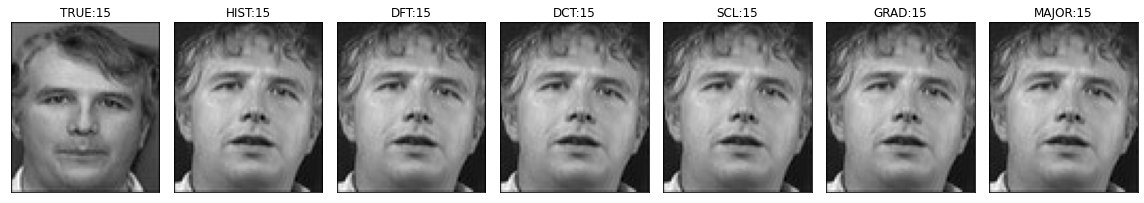

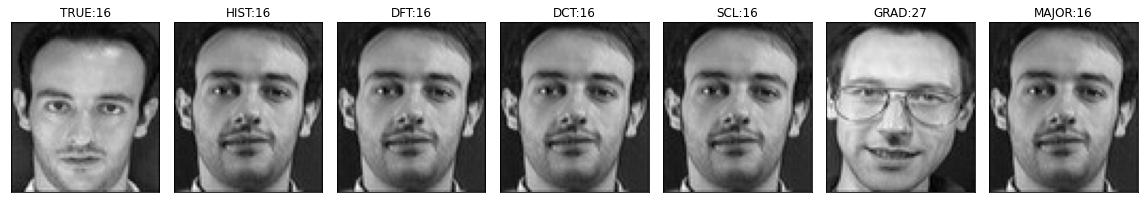

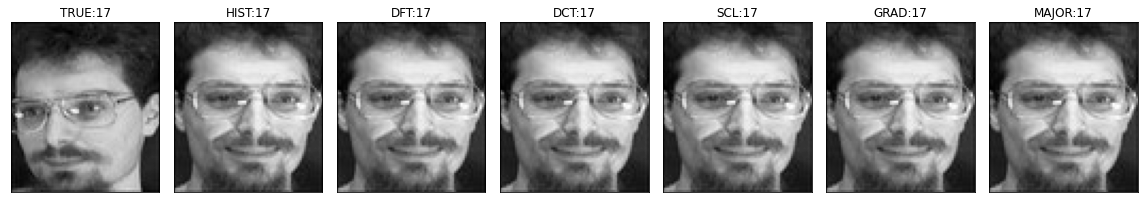

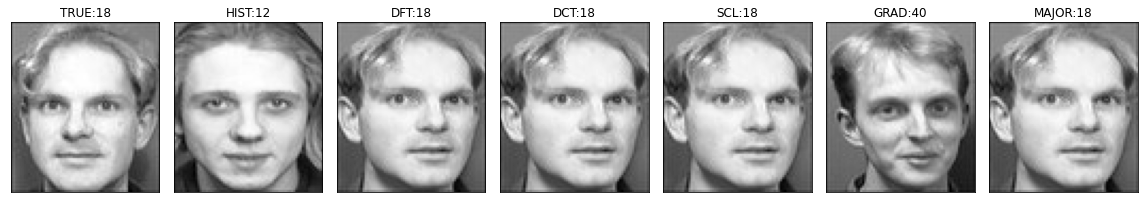

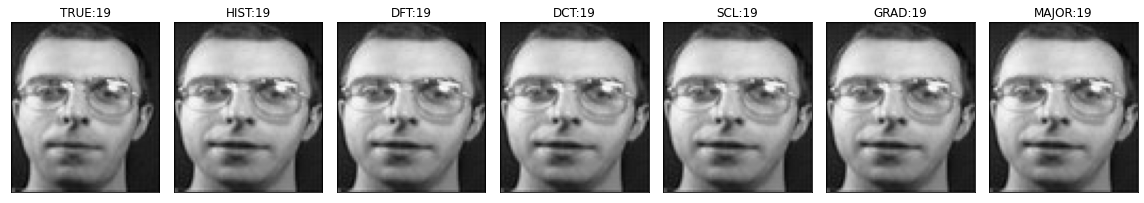

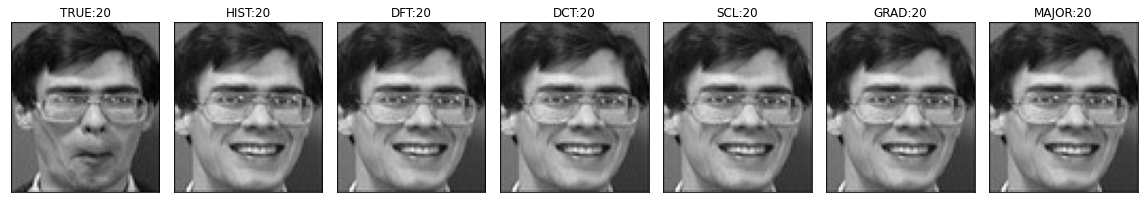

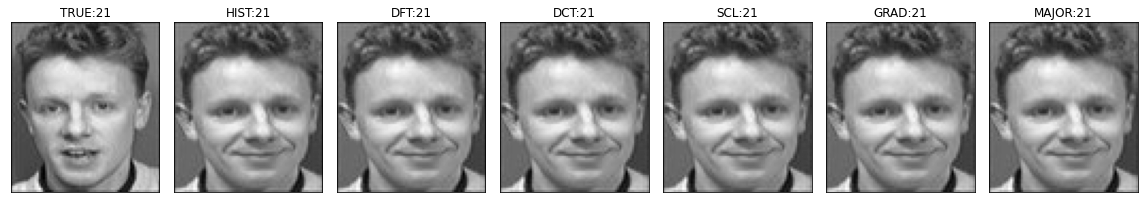

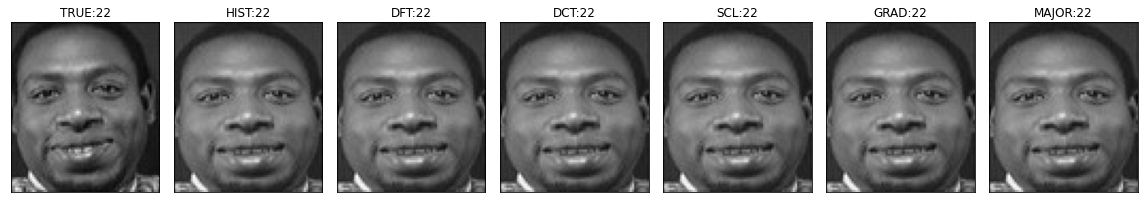

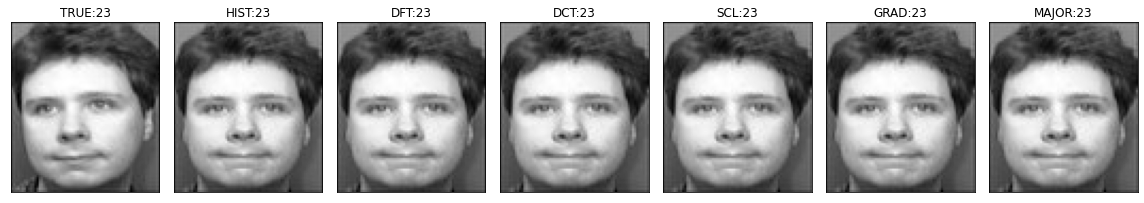

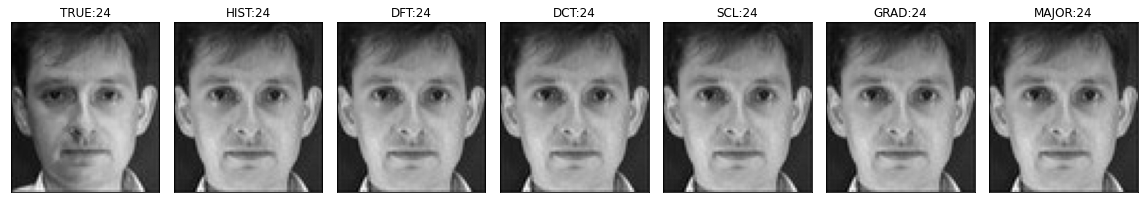

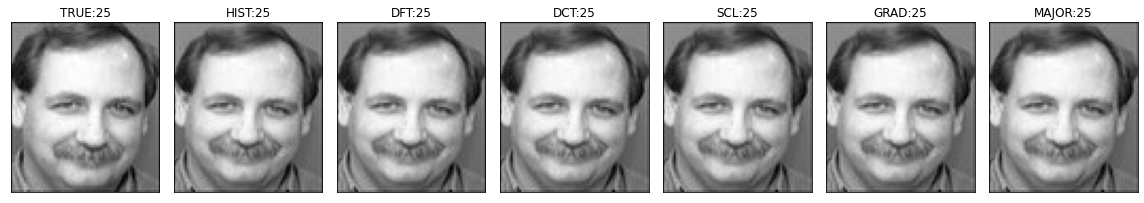

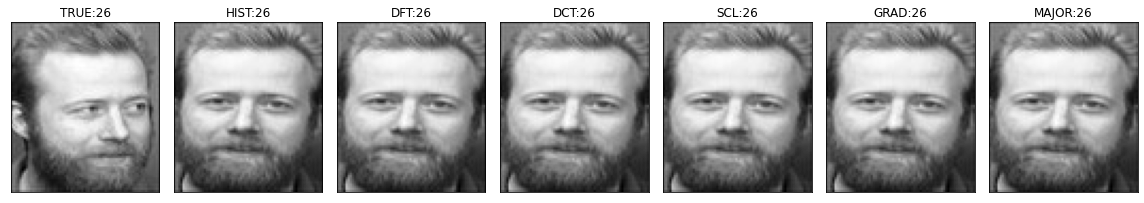

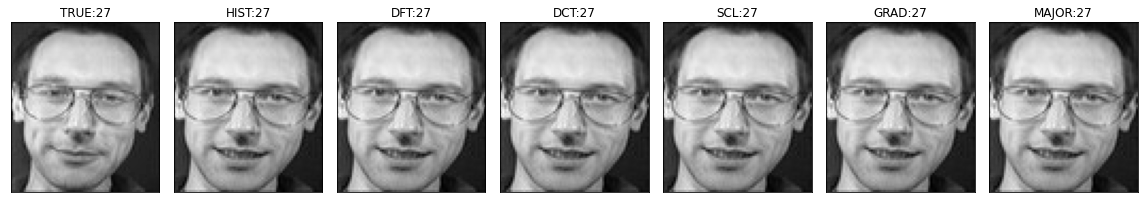

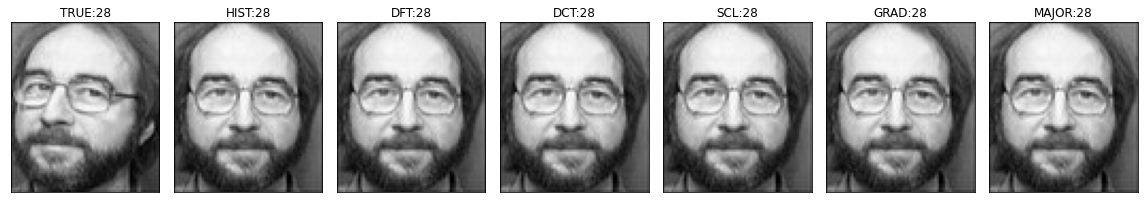

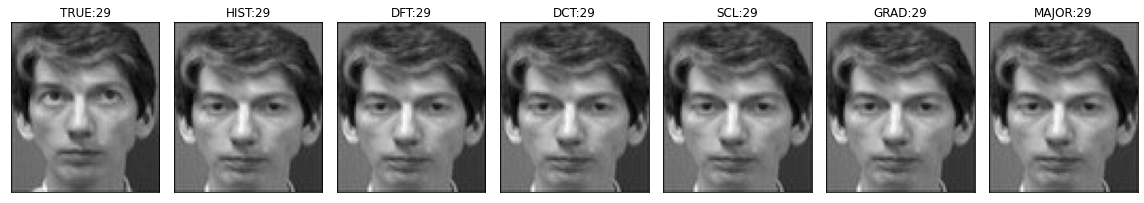

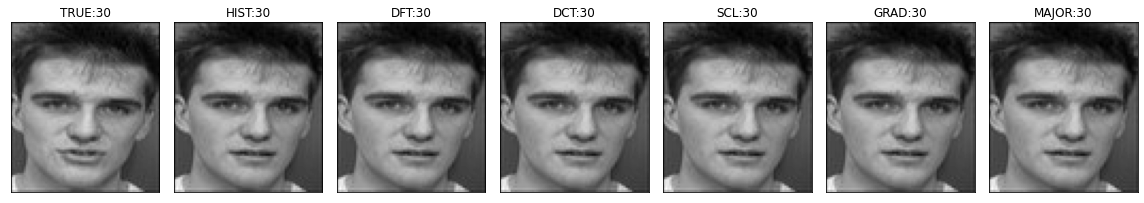

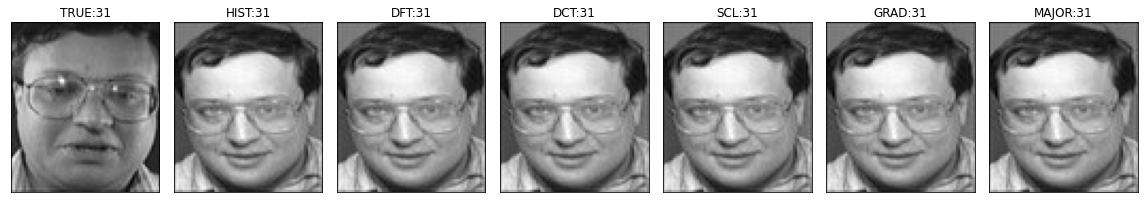

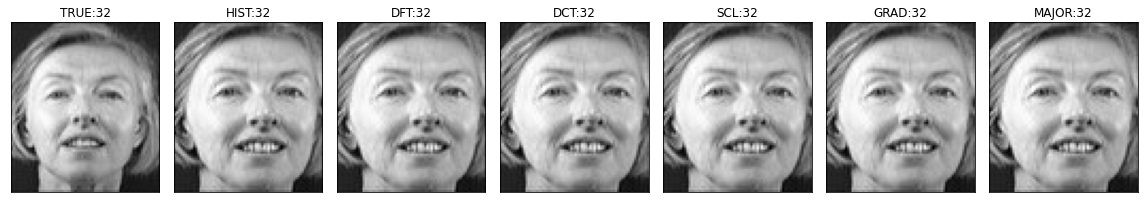

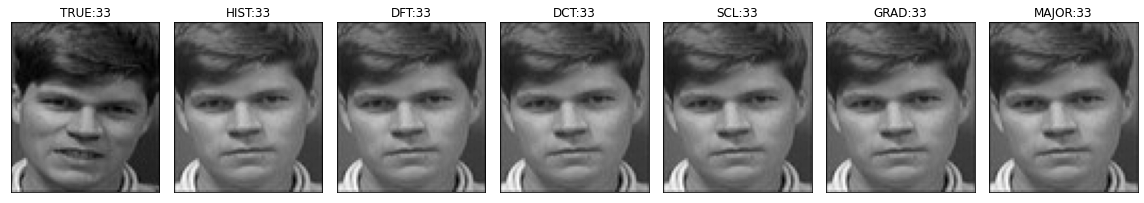

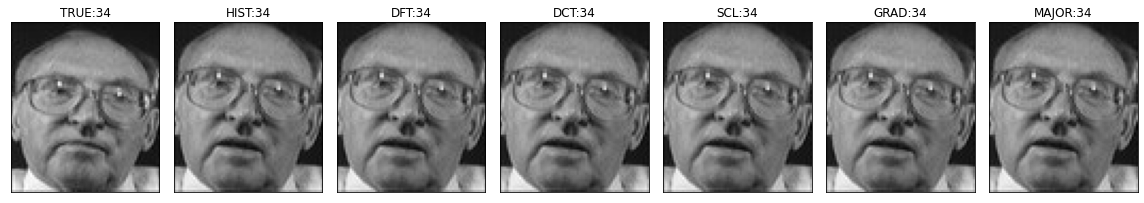

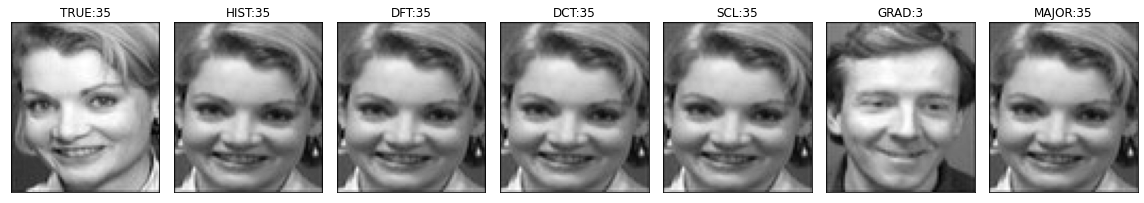

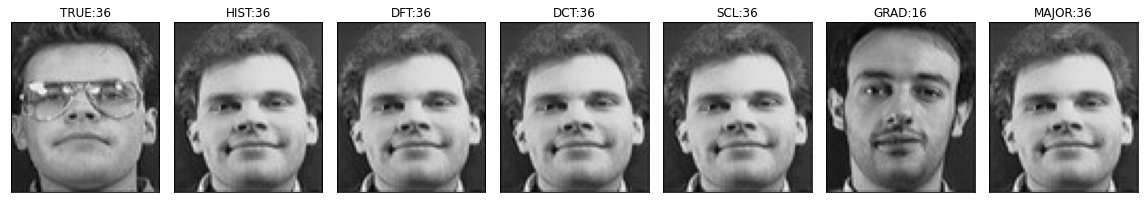

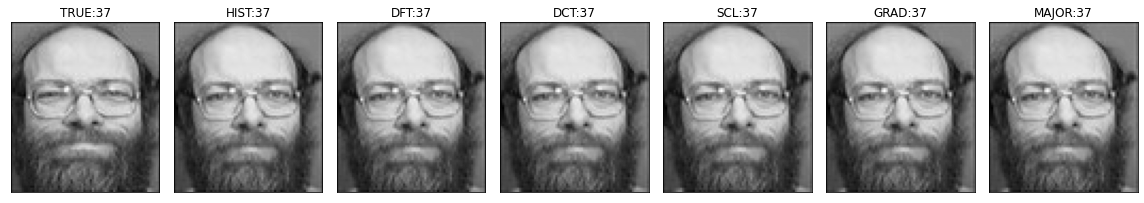

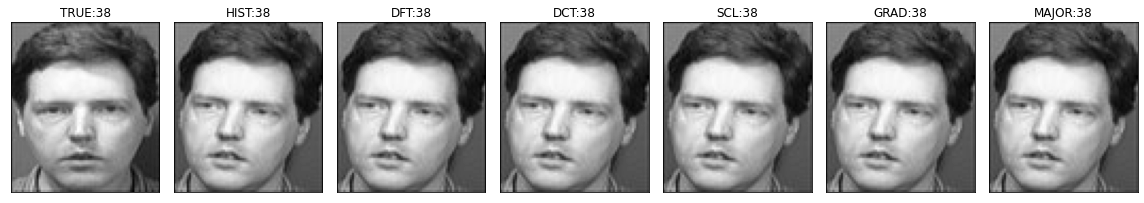

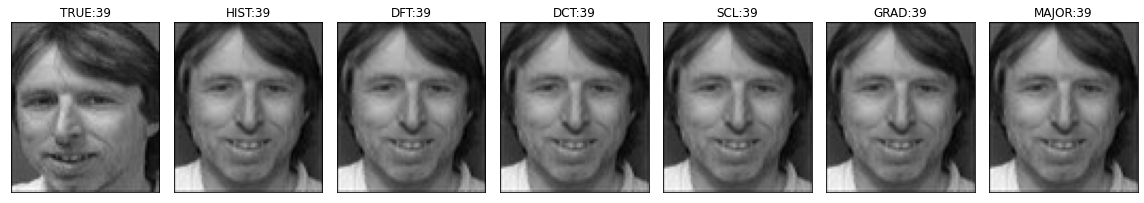

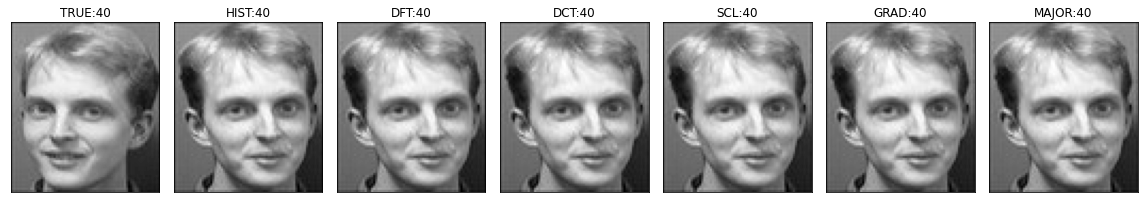

In [42]:
clfs = []
types = [TypeClassifier.HIST, TypeClassifier.DFT, TypeClassifier.DCT, TypeClassifier.SCALE, TypeClassifier.GRAD]

i = 0
for type, param in zip(types, best_params):
    clf = Classifier(type, CLASSCOUNT, 10)
    clf.fit(DIR, all_files_names, best_train_sizes_per_clf[i], best_params[param])
    clfs.append(clf)
    i += 1

clf = MajorClassifier(best_params)
# clf.fit(DIR, all_files_names, {i:best_train_size_for_major for i in range(len(types))})
clf.fit(DIR, all_files_names, best_train_sizes_per_clf)
clfs.append(clf)

# path_to_img = './ORL/renamed/31_9.jpg'
# path_to_img = './ORL/renamed/masks/31_9-with-mask.jpg'

# plot_predicted_labels('./ORL/renamed/16_10.jpg', clfs)
for i in range(1, 41):
    try:
        plot_predicted_labels(f'./ORL/renamed/{i}_10.jpg', clfs)
    except Exception as inst:
        pass
# plot_predicted_labels('./ORL/renamed/masks/31_1-with-mask.jpg', clfs)
# plot_predicted_labels('./ORL/renamed/cloaked/31_1_low_cloaked.jpg', clfs)

### GUI

In [8]:
import tkinter
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_tkagg import (
                                    FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.figure import Figure

root = tkinter.Tk()
root.wm_title("Embedding in Tk")

fig = Figure(figsize=(5, 4), dpi=100)

canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea.
canvas.draw()

ax = fig.add_subplot(111, projection="3d")
t = np.arange(0, 3, .01)
ax.plot(t, 2 * np.sin(2 * np.pi * t))

toolbar = NavigationToolbar2Tk(canvas, root)
toolbar.update()
canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)


tkinter.mainloop()
